In [1]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
pip show wandb

Name: wandb
Version: 0.18.7
Summary: A CLI and library for interacting with the Weights & Biases API.
Home-page: 
Author: 
Author-email: Weights & Biases <support@wandb.com>
License: MIT License
        
        Copyright (c) 2021 Weights and Biases, Inc.
        
        Permission is hereby granted, free of charge, to any person obtaining a copy
        of this software and associated documentation files (the "Software"), to deal
        in the Software without restriction, including without limitation the rights
        to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
        copies of the Software, and to permit persons to whom the Software is
        furnished to do so, subject to the following conditions:
        
        The above copyright notice and this permission notice shall be included in all
        copies or substantial portions of the Software.
        
        THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
        IM

In [3]:
import wandb
wandb.login

<function wandb.sdk.wandb_login.login(anonymous: Optional[Literal['must', 'allow', 'never']] = None, key: Optional[str] = None, relogin: Optional[bool] = None, host: Optional[str] = None, force: Optional[bool] = None, timeout: Optional[int] = None, verify: bool = False) -> bool>

In [4]:
import wandb
wandb.login(key="afebcaccd9929fcb34d6e10db06a3c432acfc56e")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: -ddj127 (-ddj127-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/work/.netrc


True

In [5]:
# FashionMNIST의 평균과 표준편차 계산
import torch
from torchvision import datasets, transforms

# FashionMNIST 데이터셋 로드
mnist_train = datasets.FashionMNIST(root='data', train=True, download=True, transform=transforms.ToTensor())

# 모든 데이터를 하나의 텐서로 합치기
all_images = torch.cat([img[0].view(-1) for img, _ in mnist_train])

# 평균과 표준편차 계산
mean = all_images.mean().item()
std = all_images.std().item()

print(f"Calculated Mean: {mean}")
print(f"Calculated Std: {std}")


Calculated Mean: 0.28604060411453247
Calculated Std: 0.3530242443084717


# 핵심 코드 주석

In [12]:
# Import necessary libraries
import os
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary  # For model structure summary
import matplotlib.pyplot as plt

In [13]:
# Check the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [14]:
# Function to load Fashion MNIST training and validation data
def get_fashion_mnist_data(batch_size=64):
    # Define transformations for data augmentation
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
        transforms.RandomRotation(15),          # Randomly rotate images within ±15 degrees
        transforms.ToTensor(),                  # Convert images to tensor
        transforms.Normalize(mean=0.286, std=0.353)  # Normalize using pre-calculated mean and std
    ])
    # Load Fashion MNIST dataset
    dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
    # Split into training (55,000 samples) and validation (5,000 samples) sets
    train_set, val_set = random_split(dataset, [55000, 5000])
    # Create data loaders for training and validation
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    return train_loader, val_loader

In [15]:
# Function to load Fashion MNIST test data
def get_fashion_mnist_test_data(batch_size=64):
    # Define transformation (only normalization, no augmentation for test data)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0.286, std=0.353)
    ])
    # Load Fashion MNIST test dataset
    test_set = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
    # Create a data loader for test data
    test_loader = DataLoader(test_set, batch_size=batch_size)
    return test_loader


In [16]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Define convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding="same"),  # First conv layer, 64 filters
            nn.BatchNorm2d(64),                              # Normalize feature maps
            nn.ReLU(),                                       # Activation function
            nn.MaxPool2d(kernel_size=2),                     # Downsample using MaxPool

            nn.Conv2d(64, 128, kernel_size=5, padding="same"),  # Second conv layer
            nn.BatchNorm2d(128),                                # Normalize feature maps
            nn.ReLU(),                                          # Activation function
            nn.MaxPool2d(kernel_size=2),                        # Downsample using MaxPool

            nn.Conv2d(128, 256, kernel_size=5, padding="same"), # Third conv layer
            nn.BatchNorm2d(256),                                # Normalize feature maps
            nn.ReLU(),                                          # Activation function
            nn.MaxPool2d(kernel_size=2)                         # Downsample using MaxPool
        )
        # Define fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                           # Flatten feature maps for dense layers
            nn.Linear(256 * 3 * 3, 256),            # First dense layer
            nn.ReLU(),                              # Activation function
            nn.Dropout(0.2),                        # Dropout for regularization
            nn.Linear(256, 10)                      # Output layer (10 classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)  # Pass input through convolutional layers
        x = self.fc_layers(x)    # Pass through fully connected layers
        return x


In [17]:
# Initialize weights for model layers
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)  # He initialization for better training stability


In [18]:
# Function to train and evaluate the model
def train_and_evaluate(model, train_loader, val_loader, epochs=20, learning_rate=0.001):
    model.to(device)  # Move model to the selected device
    model.apply(initialize_weights)  # Apply weight initialization
    optimizer = Adam(model.parameters(), lr=learning_rate)  # Optimizer
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate scheduler
    criterion = nn.CrossEntropyLoss()  # Loss function

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()  # Set model to training mode
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()  # Clear gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get predictions
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        scheduler.step()  # Adjust learning rate
        train_accuracy = train_correct / train_total

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return model


In [19]:
# Function to evaluate the model on test data
def evaluate_test_data(model, test_loader):
    model.eval()  # Set model to evaluation mode
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.4f}")
    return test_accuracy

In [20]:
# Function to visualize predictions
def visualize_predictions(model, test_loader, num_samples=10):
    model.eval()
    images, labels = next(iter(test_loader))  # Fetch a batch of test data
    images, labels = images.to(device), labels.to(device)

    # Select random samples for visualization
    indices = random.sample(range(len(images)), num_samples)
    selected_images = images[indices]
    selected_labels = labels[indices]

    with torch.no_grad():
        outputs = model(selected_images)  # Get predictions for selected samples
        _, predicted = torch.max(outputs, 1)

    # Plot the results
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = selected_images[i].cpu().squeeze()
        label = selected_labels[i].item()
        pred = predicted[i].item()
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Label: {label}\nPred: {pred}\n{'Correct' if label == pred else 'Wrong'}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


Model Summary:
Epoch 1/20 - Train Loss: 489.7960, Train Acc: 0.7971, Val Loss: 32.5336, Val Acc: 0.8522
Epoch 2/20 - Train Loss: 322.9123, Train Acc: 0.8628, Val Loss: 25.3313, Val Acc: 0.8814
Epoch 3/20 - Train Loss: 281.1800, Train Acc: 0.8807, Val Loss: 25.0492, Val Acc: 0.8824
Epoch 4/20 - Train Loss: 257.1715, Train Acc: 0.8908, Val Loss: 24.5417, Val Acc: 0.8854
Epoch 5/20 - Train Loss: 240.5925, Train Acc: 0.8965, Val Loss: 21.9141, Val Acc: 0.8970
Epoch 6/20 - Train Loss: 228.9604, Train Acc: 0.9029, Val Loss: 23.3361, Val Acc: 0.8890
Epoch 7/20 - Train Loss: 215.2766, Train Acc: 0.9085, Val Loss: 20.8814, Val Acc: 0.9022
Epoch 8/20 - Train Loss: 205.7806, Train Acc: 0.9128, Val Loss: 19.6719, Val Acc: 0.9112
Epoch 9/20 - Train Loss: 196.6733, Train Acc: 0.9164, Val Loss: 21.2644, Val Acc: 0.8958
Epoch 10/20 - Train Loss: 188.5876, Train Acc: 0.9197, Val Loss: 18.7308, Val Acc: 0.9110
Epoch 11/20 - Train Loss: 153.1880, Train Acc: 0.9336, Val Loss: 16.3315, Val Acc: 0.9198
Epo

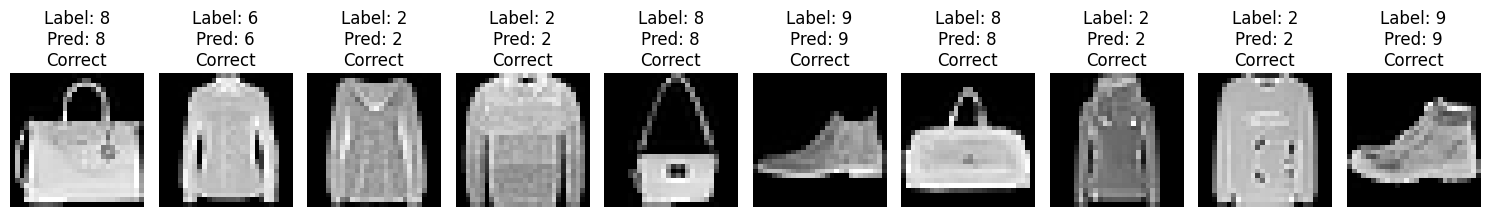

In [21]:

# Main execution
if __name__ == "__main__":
    batch_size = 64
    epochs = 20
    learning_rate = 0.001

    # Data loaders
    train_loader, val_loader = get_fashion_mnist_data(batch_size)
    test_loader = get_fashion_mnist_test_data(batch_size)

    # Model
    model = CNNModel()
    print("\nModel Summary:")
    summary(model, input_size=(batch_size, 1, 28, 28), col_names=["input_size", "output_size", "num_params", "trainable"])

    # Training and evaluation
    model = train_and_evaluate(model, train_loader, val_loader, epochs, learning_rate)

    # Test evaluation
    evaluate_test_data(model, test_loader)

    # Visualize predictions
    visualize_predictions(model, test_loader, num_samples=10)


# ResNet18라는 것을 사용해서 acc를 높이겠습니다. 94 목표
out of memory가 나오네요

In [1]:
import torch
from torch import nn
from torchvision.models.resnet import ResNet, Bottleneck
from torchinfo import summary
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Wide Residual Network (WRN) implementation using Bottleneck block
class WideResNet(ResNet):
    def __init__(self, widen_factor=4, num_classes=10):
        # Bottleneck block allows width_per_group to be adjusted
        super(WideResNet, self).__init__(
            block=Bottleneck,
            layers=[3, 4, 6, 3],  # ResNet50 configuration (deeper than ResNet18)
            num_classes=num_classes,
            width_per_group=64 * widen_factor  # Apply widen factor
        )
        # Modify the first convolutional layer to accept grayscale input
        self.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )

# Data loaders
def get_fashion_mnist_data(batch_size=64):
    transform = transforms.Compose([
        transforms.RandomCrop(28, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.286, std=0.353),
    ])
    dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
    train_set, val_set = random_split(dataset, [55000, 5000])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    return train_loader, val_loader

def get_fashion_mnist_test_data(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0.286, std=0.353),
    ])
    test_set = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
    test_loader = DataLoader(test_set, batch_size=batch_size)
    return test_loader

# Training and validation
def train_and_evaluate(model, train_loader, val_loader, epochs=20, learning_rate=0.001):
    model.to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        scheduler.step()
        train_accuracy = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return model

# Test evaluation
def evaluate_test_data(model, test_loader):
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.4f}")
    return test_accuracy

# Main execution
if __name__ == "__main__":
    batch_size = 32
    epochs = 20
    learning_rate = 0.001

    # Load data
    train_loader, val_loader = get_fashion_mnist_data(batch_size)
    test_loader = get_fashion_mnist_test_data(batch_size)

    # Initialize WRN model
    model = WideResNet(widen_factor=4)
    print("\nModel Summary:")
    summary(model, input_size=(batch_size, 1, 28, 28), col_names=["input_size", "output_size", "num_params", "trainable"])

    # Train and validate
    model = train_and_evaluate(model, train_loader, val_loader, epochs, learning_rate)

    # Test evaluation
    evaluate_test_data(model, test_loader)


Using device: cuda

Model Summary:


OutOfMemoryError: CUDA out of memory. Tried to allocate 36.00 MiB. GPU 0 has a total capacity of 31.74 GiB of which 4.88 MiB is free. Including non-PyTorch memory, this process has 3.77 GiB memory in use. Of the allocated memory 3.37 GiB is allocated by PyTorch, and 24.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# 최신 3 ResNet18
from pathlib import Path
import os
import torch
import wandb
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms
from torch.optim import Adam

# Use the current working directory
BASE_PATH = Path().resolve()
print(BASE_PATH)

import sys
sys.path.append(str(BASE_PATH))

from utils import get_num_cpu_cores, is_linux, is_windows


def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

    num_data_loading_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0
    print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    return train_data_loader, validation_data_loader


def train_and_evaluate(epochs, train_data_loader, validation_data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load ResNet18 and modify for FashionMNIST
    model = models.resnet18(pretrained=False)  # Load ResNet18 without pre-trained weights
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Modify for single-channel input
    model.fc = nn.Linear(model.fc.in_features, 10)  # Modify the output layer for 10 classes
    model = model.to(device)

    optimizer = Adam(model.parameters(), lr=wandb.config.learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_data_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = train_correct / train_total
        train_loss /= len(train_data_loader)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in validation_data_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        val_loss /= len(validation_data_loader)

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy
        })

        print(f"Epoch [{epoch}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


if __name__ == "__main__":
    config = {"batch_size": 64, "learning_rate": 0.0005, "epochs": 25}
    wandb.init(mode="disabled", config=config)

    train_data_loader, validation_data_loader = get_fashion_mnist_data()

    # Start training and evaluating
    train_and_evaluate(wandb.config.epochs, train_data_loader, validation_data_loader)

    wandb.finish()


/home/work/DL
Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25] - Train Loss: 0.4282, Train Acc: 0.8444, Val Loss: 0.3633, Val Acc: 0.8630
Epoch [2/25] - Train Loss: 0.3026, Train Acc: 0.8890, Val Loss: 0.2985, Val Acc: 0.8834
Epoch [3/25] - Train Loss: 0.2626, Train Acc: 0.9023, Val Loss: 0.2906, Val Acc: 0.8916
Epoch [4/25] - Train Loss: 0.2306, Train Acc: 0.9148, Val Loss: 0.3073, Val Acc: 0.8880
Epoch [5/25] - Train Loss: 0.2095, Train Acc: 0.9227, Val Loss: 0.2857, Val Acc: 0.8938
Epoch [6/25] - Train Loss: 0.1892, Train Acc: 0.9284, Val Loss: 0.2791, Val Acc: 0.9030
Epoch [7/25] - Train Loss: 0.1699, Train Acc: 0.9365, Val Loss: 0.2903, Val Acc: 0.9050
Epoch [8/25] - Train Loss: 0.1508, Train Acc: 0.9430, Val Loss: 0.3259, Val Acc: 0.8954
Epoch [9/25] - Train Loss: 0.1390, Train Acc: 0.9481, Val Loss: 0.2833, Val Acc: 0.9012
Epoch [10/25] - Train Loss: 0.1206, Train Acc: 0.9541, Val Loss: 0.3286, Val Acc: 0.8968
Epoch [11/25] - Train Loss: 0.1124, Train Acc: 0.9575, Val Loss: 0.2782, Val Acc: 0.9112
Epoch [12/25] - Train Loss: 0.

/home/work/DL
Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/25] - Train Loss: 0.5291, Train Acc: 0.8052, Val Loss: 0.3900, Val Acc: 0.8570
Epoch [2/25] - Train Loss: 0.3796, Train Acc: 0.8595, Val Loss: 0.3604, Val Acc: 0.8702
Epoch [3/25] - Train Loss: 0.3409, Train Acc: 0.8727, Val Loss: 0.3287, Val Acc: 0.8774
Epoch [4/25] - Train Loss: 0.3166, Train Acc: 0.8827, Val Loss: 0.3252, Val Acc: 0.8794
Epoch [5/25] - Train Loss: 0.2985, Train Acc: 0.8897, Val Loss: 0.3240, Val Acc: 0.8800
Epoch [6/25] - Train Loss: 0.2864, Train Acc: 0.8939, Val Loss: 0.2803, Val Acc: 0.9040
Epoch [7/25] - Train Loss: 0.2701, Train Acc: 0.8994, Val Loss: 0.2799, Val Acc: 0.8966
Epoch [8/25] - Train Loss: 0.2661, Train Acc: 0.9003, Val Loss: 0.2647, Val Acc: 0.9016
Epoch [9/25] - Train Loss: 0.2535, Train Acc: 0.9056, Val Loss: 0.2651, Val Acc: 0.9030
Epoch [10/25] - Train Loss: 0.2431, Train Acc: 0.9089, Val Loss: 0.2802, Val Acc: 0.8910
Epoch [11/25] - Train Loss: 0.2364, Train Acc: 0.9121, Val Loss: 0.2435, Val Acc: 0.9100
Epoch [12/25] - Train Loss: 0.

In [3]:
from pathlib import Path
import os
import torch
import wandb
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim import Adam

# Use the current working directory
BASE_PATH = Path().resolve()
print(BASE_PATH)

import sys
sys.path.append(str(BASE_PATH))

from utils import get_num_cpu_cores, is_linux, is_windows


def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0.286, std=0.353)
    ])

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

    num_data_loading_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0
    print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    return train_data_loader, validation_data_loader


def train_and_evaluate(epochs, train_data_loader, validation_data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # CNN 모델 구조 변경 (Keras 코드 참고)
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=5, padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),  # Output: (64, 14, 14)

        nn.Conv2d(64, 128, kernel_size=5, padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),  # Output: (128, 7, 7)

        nn.Conv2d(128, 256, kernel_size=5, padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),  # Output: (256, 3, 3)

        nn.Flatten(),                # Flatten for Fully Connected Layer
        nn.Linear(256 * 3 * 3, 256), # Fully Connected Layer
        nn.ReLU(),
        nn.Linear(256, 10)           # Output Layer for 10 Classes
    ).to(device)

    optimizer = Adam(model.parameters(), lr=wandb.config.learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_data_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = train_correct / train_total
        train_loss /= len(train_data_loader)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in validation_data_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        val_loss /= len(validation_data_loader)

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy
        })

        print(f"Epoch [{epoch}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


if __name__ == "__main__":
    config = {"batch_size": 64, "learning_rate": 0.0005, "epochs": 25}
    wandb.init(mode="disabled", config=config)

    train_data_loader, validation_data_loader = get_fashion_mnist_data()

    # Start training and evaluating
    train_and_evaluate(wandb.config.epochs, train_data_loader, validation_data_loader)

    wandb.finish()


/home/work/DL
Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 2
Epoch [1/25] - Train Loss: 0.4332, Train Acc: 0.8412, Val Loss: 0.2992, Val Acc: 0.8882
Epoch [2/25] - Train Loss: 0.2721, Train Acc: 0.8996, Val Loss: 0.2647, Val Acc: 0.8976
Epoch [3/25] - Train Loss: 0.2205, Train Acc: 0.9179, Val Loss: 0.2585, Val Acc: 0.9022
Epoch [4/25] - Train Loss: 0.1840, Train Acc: 0.9329, Val Loss: 0.2224, Val Acc: 0.9188
Epoch [5/25] - Train Loss: 0.1539, Train Acc: 0.9436, Val Loss: 0.2132, Val Acc: 0.9212
Epoch [6/25] - Train Loss: 0.1259, Train Acc: 0.9523, Val Loss: 0.2209, Val Acc: 0.9238
Epoch [7/25] - Train Loss: 0.0999, Train Acc: 0.9629, Val Loss: 0.2361, Val Acc: 0.9170
Epoch [8/25] - Train Loss: 0.0811, Train Acc: 0.9691, Val Loss: 0.2755, Val Acc: 0.9194
Epoch [9/25] - Train Loss: 0.0642, Train Acc: 0.9755, Val Loss: 0.2852, Val Acc: 0.9188
Epoch [10/25] - Train Loss: 0.0542, Train Acc: 0.9799, Val Loss: 

In [5]:
# 기존 코드 변경 요구 및 val acc 향상 요구
# 최대 93.7까지 23쯤?
from pathlib import Path
import os
import torch
import wandb
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

# Use the current working directory
BASE_PATH = Path().resolve()

def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    # 데이터 증강 추가
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 좌우 반전
        transforms.RandomRotation(15),          # -15도에서 15도 사이로 회전
        transforms.ToTensor(),
        transforms.Normalize(mean=0.286, std=0.353)  # 데이터 정규화
    ])

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True, pin_memory=True, num_workers=0
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size, pin_memory=True, num_workers=0
    )

    return train_data_loader, validation_data_loader


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding="same"),
            nn.BatchNorm2d(64),  # Batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Output: (64, 14, 14)

            nn.Conv2d(64, 128, kernel_size=5, padding="same"),
            nn.BatchNorm2d(128),  # Batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Output: (128, 7, 7)

            nn.Conv2d(128, 256, kernel_size=5, padding="same"),
            nn.BatchNorm2d(256),  # Batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   # Output: (256, 3, 3)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),                           # Flatten for Fully Connected Layer
            nn.Linear(256 * 3 * 3, 256),            # Fully Connected Layer
            nn.ReLU(),
            nn.Dropout(0.2),                        # Dropout 추가
            nn.Linear(256, 10)                      # Output Layer for 10 Classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


def train_and_evaluate(epochs, train_data_loader, validation_data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model 정의 및 가중치 초기화
    model = CNNModel().to(device)
    model.apply(initialize_weights)  # 가중치 초기화

    optimizer = Adam(model.parameters(), lr=wandb.config.learning_rate)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 10 epoch마다 학습률 90% 감소
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_data_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        scheduler.step()  # 학습률 업데이트

        train_accuracy = train_correct / train_total
        train_loss /= len(train_data_loader)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in validation_data_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        val_loss /= len(validation_data_loader)

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy
        })

        print(f"Epoch [{epoch}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


# 가중치 초기화 함수
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)  # He Initialization


if __name__ == "__main__":
    config = {"batch_size": 64, "learning_rate": 0.0005, "epochs": 100}
    wandb.init(project="fashion-mnist-project", config=config, name="64, 0.0005,100")

    train_data_loader, validation_data_loader = get_fashion_mnist_data()

    # Start training and evaluating
    train_and_evaluate(wandb.config.epochs, train_data_loader, validation_data_loader)

    wandb.finish()


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▄▅▆▆▆▆▆▇▇▇█████████████████████████████
train_loss,█▅▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▅▅▆▆▆▇▇▇██▇█▇███████████▇███▇████████
val_loss,█▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,56
train_accuracy,0.95122
train_loss,0.13134
val_accuracy,0.9312
val_loss,0.20071


Epoch [1/100] - Train Loss: 0.5497, Train Acc: 0.8029, Val Loss: 0.3988, Val Acc: 0.8482
Epoch [2/100] - Train Loss: 0.3792, Train Acc: 0.8609, Val Loss: 0.3348, Val Acc: 0.8748
Epoch [3/100] - Train Loss: 0.3306, Train Acc: 0.8780, Val Loss: 0.3082, Val Acc: 0.8862
Epoch [4/100] - Train Loss: 0.3020, Train Acc: 0.8894, Val Loss: 0.3225, Val Acc: 0.8790
Epoch [5/100] - Train Loss: 0.2817, Train Acc: 0.8973, Val Loss: 0.2590, Val Acc: 0.9016
Epoch [6/100] - Train Loss: 0.2653, Train Acc: 0.9028, Val Loss: 0.2721, Val Acc: 0.9008
Epoch [7/100] - Train Loss: 0.2530, Train Acc: 0.9072, Val Loss: 0.2521, Val Acc: 0.9070
Epoch [8/100] - Train Loss: 0.2437, Train Acc: 0.9086, Val Loss: 0.2350, Val Acc: 0.9090
Epoch [9/100] - Train Loss: 0.2317, Train Acc: 0.9151, Val Loss: 0.2413, Val Acc: 0.9112
Epoch [10/100] - Train Loss: 0.2234, Train Acc: 0.9175, Val Loss: 0.2353, Val Acc: 0.9110
Epoch [11/100] - Train Loss: 0.1876, Train Acc: 0.9309, Val Loss: 0.2050, Val Acc: 0.9224
Epoch [12/100] - Tr

KeyboardInterrupt: 

In [6]:
from pathlib import Path
import os
import torch
import wandb
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

# Use the current working directory
BASE_PATH = Path().resolve()

def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    # 데이터 증강 추가
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 좌우 반전
        transforms.RandomRotation(15),          # -15도에서 15도 사이로 회전
        transforms.ToTensor(),
        transforms.Normalize(mean=0.286, std=0.353)  # 데이터 정규화
    ])

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True, pin_memory=True, num_workers=0
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size, pin_memory=True, num_workers=0
    )

    return train_data_loader, validation_data_loader


def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0.286, std=0.353)  # 테스트 데이터에도 동일한 정규화 적용
    ])
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)

    test_data_loader = DataLoader(
        dataset=f_mnist_test, batch_size=wandb.config.batch_size, pin_memory=True, num_workers=0
    )
    return test_data_loader


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding="same"),
            nn.BatchNorm2d(64),  # Batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Output: (64, 14, 14)

            nn.Conv2d(64, 128, kernel_size=5, padding="same"),
            nn.BatchNorm2d(128),  # Batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Output: (128, 7, 7)

            nn.Conv2d(128, 256, kernel_size=5, padding="same"),
            nn.BatchNorm2d(256),  # Batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   # Output: (256, 3, 3)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),                           # Flatten for Fully Connected Layer
            nn.Linear(256 * 3 * 3, 256),            # Fully Connected Layer
            nn.ReLU(),
            nn.Dropout(0.2),                        # Dropout 추가
            nn.Linear(256, 10)                      # Output Layer for 10 Classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


def train_and_evaluate(epochs, train_data_loader, validation_data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model 정의 및 가중치 초기화
    model = CNNModel().to(device)
    model.apply(initialize_weights)  # 가중치 초기화

    optimizer = Adam(model.parameters(), lr=wandb.config.learning_rate)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 10 epoch마다 학습률 90% 감소
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_data_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        scheduler.step()  # 학습률 업데이트

        train_accuracy = train_correct / train_total
        train_loss /= len(train_data_loader)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in validation_data_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        val_loss /= len(validation_data_loader)

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy
        })

        print(f"Epoch [{epoch}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return model  # 학습된 모델 반환


def evaluate_test_data(model, test_data_loader, device):
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for images, labels in test_data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / test_total
    return test_accuracy


# 가중치 초기화 함수
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)  # He Initialization


if __name__ == "__main__":
    config = {"batch_size": 64, "learning_rate": 0.0005, "epochs": 50}
    wandb.init(project="fashion-mnist-project", config=config, name="64, 0.0005,100,tstAcc")

    train_data_loader, validation_data_loader = get_fashion_mnist_data()
    test_data_loader = get_fashion_mnist_test_data()

    # Start training and evaluating
    trained_model = train_and_evaluate(wandb.config.epochs, train_data_loader, validation_data_loader)

    # Evaluate on test data
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_accuracy = evaluate_test_data(trained_model, test_data_loader, device)

    # Log test accuracy to wandb
    wandb.log({"test_accuracy": test_accuracy})
    print(f"Test Accuracy: {test_accuracy:.4f}")

    wandb.finish()


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▄▅▅▆▆▆▆▆▆▇▇▇███████████████████████
train_loss,█▅▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▃▅▅▆▆▆▆▇▇▇▇█▇█████████████▇██████
val_loss,█▆▅▆▄▄▃▃▃▃▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,36
train_accuracy,0.94764
train_loss,0.14
val_accuracy,0.9334
val_loss,0.18785


Epoch [1/50] - Train Loss: 0.5589, Train Acc: 0.8009, Val Loss: 0.3725, Val Acc: 0.8574
Epoch [2/50] - Train Loss: 0.3834, Train Acc: 0.8595, Val Loss: 0.3178, Val Acc: 0.8812
Epoch [3/50] - Train Loss: 0.3306, Train Acc: 0.8781, Val Loss: 0.3074, Val Acc: 0.8800
Epoch [4/50] - Train Loss: 0.3072, Train Acc: 0.8881, Val Loss: 0.2890, Val Acc: 0.8918
Epoch [5/50] - Train Loss: 0.2843, Train Acc: 0.8954, Val Loss: 0.2773, Val Acc: 0.8952
Epoch [6/50] - Train Loss: 0.2661, Train Acc: 0.9014, Val Loss: 0.2615, Val Acc: 0.9016
Epoch [7/50] - Train Loss: 0.2557, Train Acc: 0.9062, Val Loss: 0.2465, Val Acc: 0.9054
Epoch [8/50] - Train Loss: 0.2421, Train Acc: 0.9100, Val Loss: 0.2923, Val Acc: 0.8932
Epoch [9/50] - Train Loss: 0.2344, Train Acc: 0.9139, Val Loss: 0.2584, Val Acc: 0.8972
Epoch [10/50] - Train Loss: 0.2258, Train Acc: 0.9161, Val Loss: 0.2375, Val Acc: 0.9126
Epoch [11/50] - Train Loss: 0.1864, Train Acc: 0.9318, Val Loss: 0.1996, Val Acc: 0.9228
Epoch [12/50] - Train Loss: 0.

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
train_accuracy,▁▄▅▅▆▆▆▆▇▇▇█████████████████████████████
train_loss,█▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▅▅▄▅▇▇▇▇▇▇▇▇█▇▇▇██████▇██████████▇▇▇
val_loss,█▆▆▅▄▃▅▄▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁
epoch,50
test_accuracy,0.9293
train_accuracy,0.94805
train_loss,0.13831
val_accuracy,0.9292


### 전에 googlene으로 보여줄 일이 있다고 하셨던 말이 기억나서 추가함...
근데 그림이나 표로 안나오네..?

In [7]:
from torchvision import datasets, transforms, models  # GoogLeNet 사용

googlenet = models.googlenet(pretrained=False, aux_logits=False)
print("\nGoogLeNet Model Structure:\n")
print(googlenet)


GoogLeNet Model Structure:

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, mom

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [8]:
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [6]:
import torch
from torch import nn
from torchinfo import summary  # torchinfo import

# Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

if __name__ == "__main__":
    # Initialize the model
    model = SimpleCNN()

    # Print model summary using torchinfo
    input_size = (128, 1, 28, 28)  # batch_size=128, channels=1, height=28, width=28
    print(summary(model, input_size=input_size, col_names=["input_size", "output_size", "num_params", "trainable"]))


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
SimpleCNN                                [128, 1, 28, 28]          [128, 10]                 --                        True
├─Conv2d: 1-1                            [128, 1, 28, 28]          [128, 32, 28, 28]         320                       True
├─Conv2d: 1-2                            [128, 32, 28, 28]         [128, 64, 28, 28]         18,496                    True
├─MaxPool2d: 1-3                         [128, 64, 28, 28]         [128, 64, 14, 14]         --                        --
├─Linear: 1-4                            [128, 12544]              [128, 128]                1,605,760                 True
├─Linear: 1-5                            [128, 128]                [128, 10]                 1,290                     True
Total params: 1,625,866
Trainable params: 1,625,866
Non-trainable params: 0
Total mult-adds (G): 2.09
Input size (MB): 0.40
Forwa

## 문제 3, 문제 4 
문제4의 내용에는 포함안되지만 최소한 1개의 테스트 이미지가 동일하지 않음이 아닌 레이블과 분류 예측이 동일하게 설정함. 1개가 무조건 아니게 하는 것은 하단에 포함하겠음

Using device: cuda

Model Summary:
Epoch 1/20 - Train Loss: 492.7378, Train Acc: 0.7947, Val Loss: 33.0454, Val Acc: 0.8374
Epoch 2/20 - Train Loss: 328.1750, Train Acc: 0.8606, Val Loss: 26.9135, Val Acc: 0.8724
Epoch 3/20 - Train Loss: 284.3532, Train Acc: 0.8778, Val Loss: 21.7702, Val Acc: 0.8976
Epoch 4/20 - Train Loss: 260.7601, Train Acc: 0.8886, Val Loss: 21.8276, Val Acc: 0.8966
Epoch 5/20 - Train Loss: 241.8697, Train Acc: 0.8970, Val Loss: 21.8927, Val Acc: 0.8950
Epoch 6/20 - Train Loss: 228.5601, Train Acc: 0.9021, Val Loss: 20.7777, Val Acc: 0.8996
Epoch 7/20 - Train Loss: 213.6508, Train Acc: 0.9087, Val Loss: 18.5639, Val Acc: 0.9114
Epoch 8/20 - Train Loss: 202.8541, Train Acc: 0.9116, Val Loss: 19.6473, Val Acc: 0.9086
Epoch 9/20 - Train Loss: 196.6834, Train Acc: 0.9153, Val Loss: 19.4991, Val Acc: 0.9086
Epoch 10/20 - Train Loss: 188.0848, Train Acc: 0.9181, Val Loss: 17.9062, Val Acc: 0.9188
Epoch 11/20 - Train Loss: 152.7850, Train Acc: 0.9340, Val Loss: 15.6826, 

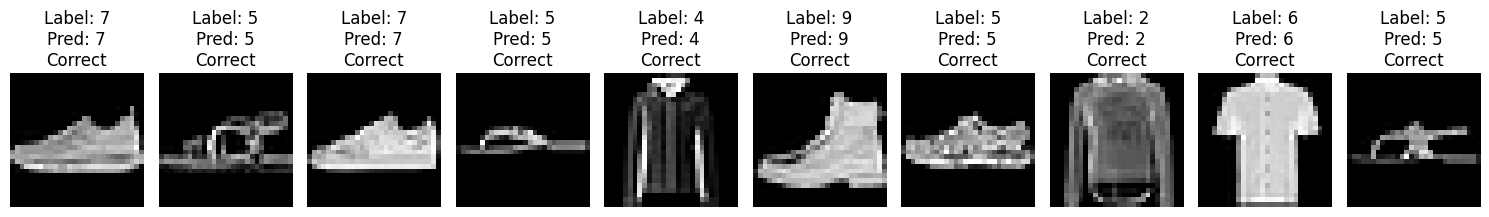

In [7]:
# Import libraries
import os
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary
import matplotlib.pyplot as plt

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data loaders
def get_fashion_mnist_data(batch_size=64):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.286, std=0.353)
    ])
    dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
    train_set, val_set = random_split(dataset, [55000, 5000])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    return train_loader, val_loader

def get_fashion_mnist_test_data(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0.286, std=0.353)
    ])
    test_set = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
    test_loader = DataLoader(test_set, batch_size=batch_size)
    return test_loader

# Define CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=5, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(128, 256, kernel_size=5, padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize weights
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)

# Training and evaluation
def train_and_evaluate(model, train_loader, val_loader, epochs=20, learning_rate=0.001):
    model.to(device)
    model.apply(initialize_weights)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        scheduler.step()
        train_accuracy = train_correct / train_total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return model

def evaluate_test_data(model, test_loader):
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.4f}")
    return test_accuracy


# Visualize predictions
def visualize_predictions(model, test_loader, num_samples=10):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    indices = random.sample(range(len(images)), num_samples)
    selected_images = images[indices]
    selected_labels = labels[indices]

    with torch.no_grad():
        outputs = model(selected_images)
        _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = selected_images[i].cpu().squeeze()
        label = selected_labels[i].item()
        pred = predicted[i].item()
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Label: {label}\nPred: {pred}\n{'Correct' if label == pred else 'Wrong'}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    batch_size = 64
    epochs = 20
    learning_rate = 0.001

    # Data loaders
    train_loader, val_loader = get_fashion_mnist_data(batch_size)
    test_loader = get_fashion_mnist_test_data(batch_size)

    # Model
    model = CNNModel()
    print("\nModel Summary:")
    summary(model, input_size=(batch_size, 1, 28, 28), col_names=["input_size", "output_size", "num_params", "trainable"])

    # Training and evaluation
    model = train_and_evaluate(model, train_loader, val_loader, epochs, learning_rate)

    # Test evaluation
    evaluate_test_data(model, test_loader)

    # Visualize predictions
    visualize_predictions(model, test_loader, num_samples=10)


Using device: cuda

Model Summary:
Epoch 1/20 - Train Loss: 508.3955, Train Acc: 0.7921, Val Loss: 39.9118, Val Acc: 0.8132
Epoch 2/20 - Train Loss: 329.3808, Train Acc: 0.8603, Val Loss: 28.8398, Val Acc: 0.8672
Epoch 3/20 - Train Loss: 286.7039, Train Acc: 0.8795, Val Loss: 25.1831, Val Acc: 0.8818
Epoch 4/20 - Train Loss: 261.1377, Train Acc: 0.8885, Val Loss: 27.4458, Val Acc: 0.8776
Epoch 5/20 - Train Loss: 246.8587, Train Acc: 0.8938, Val Loss: 22.5386, Val Acc: 0.8944
Epoch 6/20 - Train Loss: 227.8867, Train Acc: 0.9026, Val Loss: 26.2912, Val Acc: 0.8790
Epoch 7/20 - Train Loss: 217.8819, Train Acc: 0.9062, Val Loss: 20.2346, Val Acc: 0.9066
Epoch 8/20 - Train Loss: 208.7526, Train Acc: 0.9097, Val Loss: 20.4965, Val Acc: 0.9120
Epoch 9/20 - Train Loss: 199.5646, Train Acc: 0.9148, Val Loss: 20.5986, Val Acc: 0.9066
Epoch 10/20 - Train Loss: 188.1443, Train Acc: 0.9192, Val Loss: 19.1594, Val Acc: 0.9110
Epoch 11/20 - Train Loss: 155.0726, Train Acc: 0.9343, Val Loss: 17.7000, 

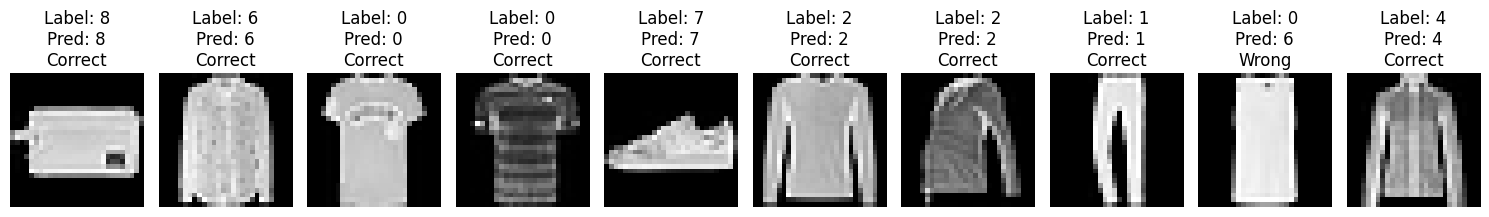

In [8]:
# Import libraries
import os
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary
import matplotlib.pyplot as plt

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data loaders
def get_fashion_mnist_data(batch_size=64):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.286, std=0.353)
    ])
    dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
    train_set, val_set = random_split(dataset, [55000, 5000])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    return train_loader, val_loader

def get_fashion_mnist_test_data(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0.286, std=0.353)
    ])
    test_set = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
    test_loader = DataLoader(test_set, batch_size=batch_size)
    return test_loader

# Define CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=5, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(128, 256, kernel_size=5, padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize weights
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)

# Training and evaluation
def train_and_evaluate(model, train_loader, val_loader, epochs=20, learning_rate=0.001):
    model.to(device)
    model.apply(initialize_weights)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        scheduler.step()
        train_accuracy = train_correct / train_total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return model

def evaluate_test_data(model, test_loader):
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_accuracy = test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.4f}")
    return test_accuracy


def visualize_predictions_with_misclassification(model, test_loader, num_samples=10):
    """
    Visualize random predictions including at least one misclassified sample.
    """
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Find misclassified samples
    correct = (predicted == labels)
    incorrect = ~correct
    incorrect_indices = torch.nonzero(incorrect).squeeze().tolist()
    if isinstance(incorrect_indices, int):  # Handle single incorrect case
        incorrect_indices = [incorrect_indices]

    # Ensure at least one misclassified sample
    selected_indices = random.sample(range(len(images)), num_samples - 1)  # Select random samples
    if incorrect_indices:  # If there are misclassified samples, include one
        selected_indices.append(incorrect_indices[0])
    else:
        print("Warning: No misclassified samples found in this batch.")
        selected_indices = random.sample(range(len(images)), num_samples)  # Fallback to random samples

    # Visualize selected samples
    selected_images = images[selected_indices]
    selected_labels = labels[selected_indices]
    selected_predictions = predicted[selected_indices]

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = selected_images[i].cpu().squeeze()
        label = selected_labels[i].item()
        pred = selected_predictions[i].item()
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Label: {label}\nPred: {pred}\n{'Correct' if label == pred else 'Wrong'}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Analyze the misclassified sample
    if incorrect_indices:
        print("\nMisclassified Sample Analysis:")
        misclassified_image = images[incorrect_indices[0]].cpu().squeeze()
        misclassified_label = labels[incorrect_indices[0]].item()
        misclassified_pred = predicted[incorrect_indices[0]].item()
        plt.figure(figsize=(3, 3))
        plt.imshow(misclassified_image, cmap="gray")
        plt.title(f"Label: {misclassified_label}, Pred: {misclassified_pred} (Wrong)")
        plt.axis("off")
        plt.show()


# Main execution
if __name__ == "__main__":
    batch_size = 64
    epochs = 20
    learning_rate = 0.001

    # Data loaders
    train_loader, val_loader = get_fashion_mnist_data(batch_size)
    test_loader = get_fashion_mnist_test_data(batch_size)

    # Model
    model = CNNModel()
    print("\nModel Summary:")
    summary(model, input_size=(batch_size, 1, 28, 28), col_names=["input_size", "output_size", "num_params", "trainable"])

    # Training and evaluation
    model = train_and_evaluate(model, train_loader, val_loader, epochs, learning_rate)

    # Test evaluation
    evaluate_test_data(model, test_loader)

    # Visualize predictions
    visualize_predictions(model, test_loader, num_samples=10)


예측 결과가 틀린 이유...
사람의 눈으로 보기에도 무엇인지 예상하기가 어렵고, flatten이든 relu, adam 등등을 사용했더라도 이미지 레이블과 일반적으로 정의되어있는 분류 예측 값이 동일하기가 어렵기 때문으로 보임....

# 문제 4

# 숙제 후기
감사합니다. 생각보다 94이상으로 올리는게 어렵네요...
하단은 시도했던 코드의 일부입니다.. 저거보다 많이 했었는데 일부만 가져왔습니다.

이런 github의 링크가 있는데 : https://github.com/zalandoresearch/fashion-mnist
하단과 같이 여러 classifier 방법들과, 어떤 모델을 사용했을때 어떤 acc가 나왔는지 에대해서 작성하신 분이 있습니다.
참고하면 좋겠다는 생각이 들어서 가져왔습니다...

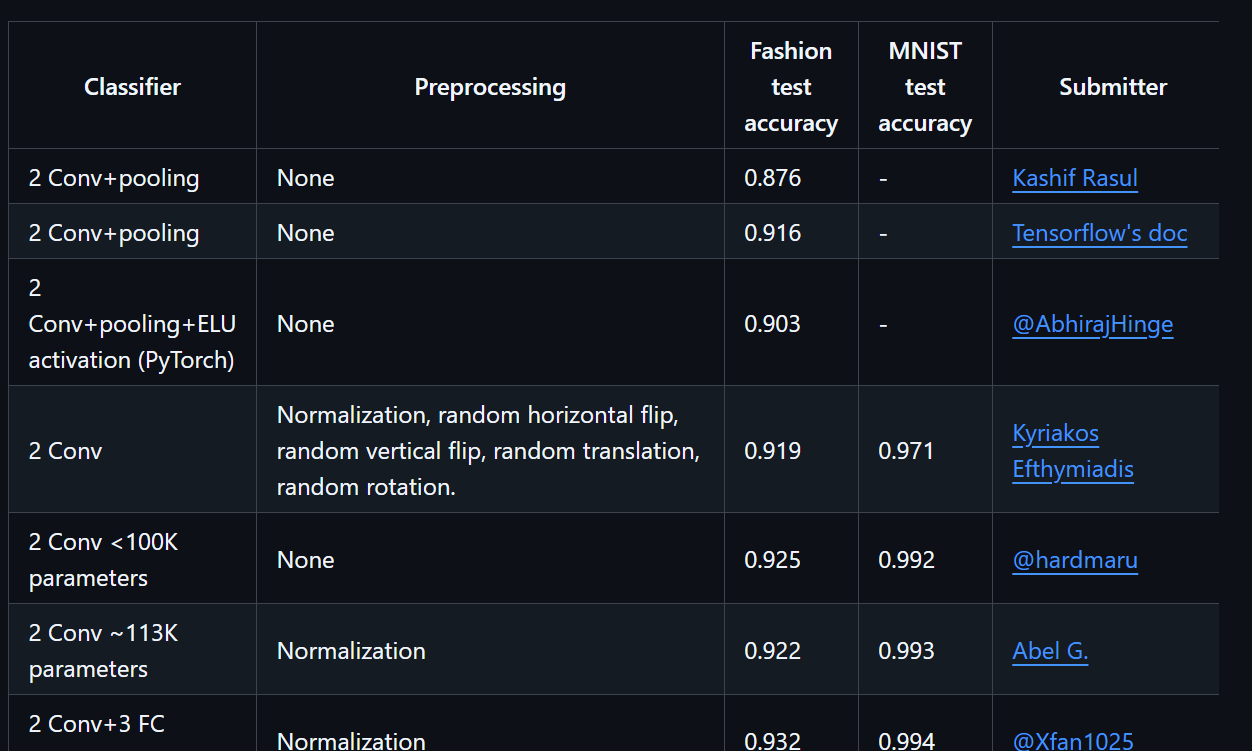

In [3]:
from pathlib import Path
import os
import torch
import wandb
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary  # torchinfo 사용

# Use the current working directory
BASE_PATH = Path().resolve()

def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    # 데이터 증강 추가
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 좌우 반전
        transforms.RandomRotation(15),          # -15도에서 15도 사이로 회전
        transforms.ToTensor(),
        transforms.Normalize(mean=0.286, std=0.353)  # 데이터 정규화
    ])

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True, pin_memory=True, num_workers=0
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size, pin_memory=True, num_workers=0
    )

    return train_data_loader, validation_data_loader


def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0.286, std=0.353)  # 테스트 데이터에도 동일한 정규화 적용
    ])
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)

    test_data_loader = DataLoader(
        dataset=f_mnist_test, batch_size=wandb.config.batch_size, pin_memory=True, num_workers=0
    )
    return test_data_loader


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding="same"),
            nn.BatchNorm2d(64),  # Batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Output: (64, 14, 14)

            nn.Conv2d(64, 128, kernel_size=5, padding="same"),
            nn.BatchNorm2d(128),  # Batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Output: (128, 7, 7)

            nn.Conv2d(128, 256, kernel_size=5, padding="same"),
            nn.BatchNorm2d(256),  # Batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   # Output: (256, 3, 3)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),                           # Flatten for Fully Connected Layer
            nn.Linear(256 * 3 * 3, 256),            # Fully Connected Layer
            nn.ReLU(),
            nn.Dropout(0.2),                        # Dropout 추가
            nn.Linear(256, 10)                      # Output Layer for 10 Classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


def train_and_evaluate(epochs, train_data_loader, validation_data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model 정의 및 가중치 초기화
    model = CNNModel().to(device)
    model.apply(initialize_weights)  # 가중치 초기화

    optimizer = Adam(model.parameters(), lr=wandb.config.learning_rate)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 10 epoch마다 학습률 90% 감소
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_data_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        scheduler.step()  # 학습률 업데이트

        train_accuracy = train_correct / train_total
        train_loss /= len(train_data_loader)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in validation_data_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        val_loss /= len(validation_data_loader)

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy
        })

        print(f"Epoch [{epoch}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return model  # 학습된 모델 반환


def evaluate_test_data(model, test_data_loader, device):
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for images, labels in test_data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / test_total
    return test_accuracy


# 가중치 초기화 함수
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)  # He Initialization


if __name__ == "__main__":
    config = {"batch_size": 64, "learning_rate": 0.0005, "epochs": 20}
    wandb.init(project="fashion-mnist-project", config=config, name="64, 0.0005,100")

    train_data_loader, validation_data_loader = get_fashion_mnist_data()
    test_data_loader = get_fashion_mnist_test_data()

    # GoogLeNet 모델 로드 및 구조 출력
    googlenet = models.googlenet(pretrained=False, aux_logits=False)
    print("\nGoogLeNet Model Structure Summary:\n")
    summary(googlenet, input_size=(64, 1, 28, 28), col_names=["input_size", "output_size", "num_params", "trainable"])

    # Start training and evaluating
    trained_model = train_and_evaluate(wandb.config.epochs, train_data_loader, validation_data_loader)

    # Evaluate on test data
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_accuracy = evaluate_test_data(trained_model, test_data_loader, device)

    # Log test accuracy to wandb
    wandb.log({"test_accuracy": test_accuracy})
    print(f"Test Accuracy: {test_accuracy:.4f}")

    wandb.finish()



GoogLeNet Model Structure Summary:



RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [3]:
def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    # 데이터 증강 추가
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 좌우 반전
        transforms.RandomRotation(15),          # -15도에서 15도 사이로 회전
        transforms.ToTensor(),
        transforms.Normalize(mean=0.286, std=0.353)  # 데이터 정규화
    ])

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding="same"),
            nn.BatchNorm2d(64),  # Batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Output: (64, 14, 14)

            nn.Conv2d(64, 128, kernel_size=5, padding="same"),
            nn.BatchNorm2d(128),  # Batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Output: (128, 7, 7)

            nn.Conv2d(128, 256, kernel_size=5, padding="same"),
            nn.BatchNorm2d(256),  # Batch Normalization 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   # Output: (256, 3, 3)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),                           # Flatten for Fully Connected Layer
            nn.Linear(256 * 3 * 3, 256),            # Fully Connected Layer
            nn.ReLU(),
            nn.Dropout(0.2),                        # Dropout 추가
            nn.Linear(256, 10)                      # Output Layer for 10 Classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


def train_and_evaluate(epochs, train_data_loader, validation_data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model 정의 및 가중치 초기화
    model = CNNModel().to(device)
    model.apply(initialize_weights)  # 가중치 초기화

    optimizer = Adam(model.parameters(), lr=wandb.config.learning_rate)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 10 epoch마다 학습률 90% 감소
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_data_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        scheduler.step()  # 학습률 업데이트



# 가중치 초기화 함수
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)  # He Initialization


if __name__ == "__main__":
    config = {"batch_size": 64, "learning_rate": 0.001, "epochs": 100}



wandb: Currently logged in as: -ddj127 (-ddj127-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin


Epoch [1/100] - Train Loss: 0.5602, Train Acc: 0.8006, Val Loss: 0.3983, Val Acc: 0.8528
Epoch [2/100] - Train Loss: 0.3753, Train Acc: 0.8632, Val Loss: 0.3567, Val Acc: 0.8732
Epoch [3/100] - Train Loss: 0.3267, Train Acc: 0.8803, Val Loss: 0.2959, Val Acc: 0.8910
Epoch [4/100] - Train Loss: 0.2978, Train Acc: 0.8908, Val Loss: 0.2906, Val Acc: 0.8936
Epoch [5/100] - Train Loss: 0.2812, Train Acc: 0.8971, Val Loss: 0.3019, Val Acc: 0.8912
Epoch [6/100] - Train Loss: 0.2646, Train Acc: 0.9031, Val Loss: 0.2712, Val Acc: 0.9008
Epoch [7/100] - Train Loss: 0.2483, Train Acc: 0.9060, Val Loss: 0.2619, Val Acc: 0.9066
Epoch [8/100] - Train Loss: 0.2368, Train Acc: 0.9126, Val Loss: 0.2543, Val Acc: 0.9086
Epoch [9/100] - Train Loss: 0.2265, Train Acc: 0.9176, Val Loss: 0.2683, Val Acc: 0.9052
Epoch [10/100] - Train Loss: 0.2166, Train Acc: 0.9202, Val Loss: 0.2570, Val Acc: 0.9110
Epoch [11/100] - Train Loss: 0.1765, Train Acc: 0.9357, Val Loss: 0.2148, Val Acc: 0.9244
Epoch [12/100] - Tr

KeyboardInterrupt: 